c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(600, 2048)
Epoch 1/50, Loss: 1.6439934968948364
Epoch 2/50, Loss: 1.6484427452087402
Epoch 3/50, Loss: 1.6103116273880005
Epoch 4/50, Loss: 1.4942964315414429
Epoch 5/50, Loss: 1.3411476612091064
Epoch 6/50, Loss: 1.2783037424087524
Epoch 7/50, Loss: 0.8992913961410522
Epoch 8/50, Loss: 0.7616831660270691
Epoch 9/50, Loss: 0.821370542049408
Epoch 10/50, Loss: 0.4730011820793152
Epoch 11/50, Loss: 0.46569061279296875
Epoch 12/50, Loss: 0.281942754983902
Epoch 13/50, Loss: 0.3708089292049408
Epoch 14/50, Loss: 0.264641135931015
Epoch 15/50, Loss: 0.23850102722644806
Epoch 16/50, Loss: 0.1633530855178833
Epoch 17/50, Loss: 0.14805980026721954
Epoch 18/50, Loss: 0.2459213137626648
Epoch 19/50, Loss: 0.26281172037124634
Epoch 20/50, Loss: 0.1283656805753708
Epoch 21/50, Loss: 0.16376812756061554
Epoch 22/50, Loss: 0.09303247928619385
Epoch 23/50, Loss: 0.10484664887189865
Epoch 24/50, Loss: 0.05647920444607735
Epoch 25/50, Loss: 0.0972374901175499
Epoch 26/50, Loss: 0.07218655943870544
Epo

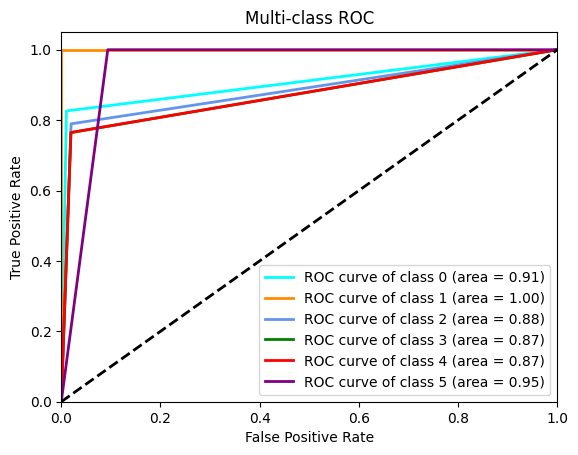

In [3]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights

# Define your dataset directory
dataset_dir = 'D:/CANCER/Prostate Cancer WSI/Prostate_Dataset(short)'

# Initialize empty lists for images and labels
images = []
labels = []

# Define a mapping of class labels to integers
class_to_int = {'GG0': 0, 'GG1': 1, 'GG2': 2, 'GG3': 3, 'GG4': 4, 'GG5': 5}

# Loop through your dataset directory to load images and labels
for category in os.listdir(dataset_dir):
    category_dir = os.path.join(dataset_dir, category)
    for img_filename in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img_filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))  # Resize images to a common size
        images.append(img)  # Keep color images
        labels.append(class_to_int[category])  # Map class labels to integers

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Load a pre-trained ResNet model
resnet = models.resnet50(pretrained=True)
resnet.eval()  # Set the model to evaluation mode

# Modify the ResNet model to remove the final layer
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)

# Define a transform for pre-processing the images for ResNet
transform_resnet = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract features using ResNet
def extract_cnn_features(model, image):
    with torch.no_grad():
        # Apply the transformations and add batch dimension
        image = transform_resnet(image).unsqueeze(0)
        if torch.cuda.is_available():
            image = image.to('cuda')
            model = model.to('cuda')
        features = model(image)
        # Remove the batch dimension and convert to numpy
        features = features.squeeze().cpu().numpy()
    return features

# Extract CNN features for each image
cnn_features_train = np.array([extract_cnn_features(resnet, img) for img in images])

# Check the shape of cnn_features_train
print(cnn_features_train.shape)  # This should give you an idea of the current shape

# Assuming cnn_features_train has shape (num_samples, num_features)
# Reshape it to (num_samples, num_channels, height, width)
# Here, num_channels = 2048 (output channels of ResNet), height = 1, width = 1

X = cnn_features_train.reshape(cnn_features_train.shape[0], 2048, 1, 1)
y = labels

# Split data into training and testing sets before scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the scaled data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create PyTorch datasets and dataloaders with the correctly processed tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(2048, 32, kernel_size=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=1, stride=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=1, stride=1)
        self.fc1 = nn.Linear(128 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 6)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 1 * 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
model = CNN()

# Example class weights for 6 classes
class_weights = torch.tensor([1.0, 2.0, 0.5, 1.5, 1.2, 0.8])

# Assuming you're using a GPU, you might need to move the weights to the same device as your model and data
if torch.cuda.is_available():
    model = model.to('cuda')
    class_weights = class_weights.to('cuda')

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 50
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    for inputs, labels in train_loader:
        if torch.cuda.is_available():
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    
# Save the model
torch.save(model.state_dict(), 'model.pth')

# Load the model
model = CNN()  # Make sure to initialize the model architecture
model.load_state_dict(torch.load('model.pth'))
model.eval()  # Set the model to evaluation mode

true_labels = []
predictions = []

with torch.no_grad():  # No need to track gradients for validation
    for inputs, labels in test_loader:
        if torch.cuda.is_available():
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Print evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predictions))
print(classification_report(true_labels, predictions))

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Accuracy: {accuracy*100}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

import numpy as np
from itertools import cycle

def plot_roc(true_labels, predictions, n_classes):
    # Convert true_labels and predictions to one-hot encoded format
    true_labels_bin = label_binarize(true_labels, classes=range(n_classes))
    predictions_bin = label_binarize(predictions, classes=range(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.show()

# Call the modified plot_roc function
plot_roc(true_labels, predictions, n_classes=6)

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(600, 2048)
Epoch 1/50, Loss: 1.5389511585235596
Epoch 2/50, Loss: 1.3250055313110352
Epoch 3/50, Loss: 1.1023558378219604
Epoch 4/50, Loss: 0.5272620916366577
Epoch 5/50, Loss: 0.4129669964313507
Epoch 6/50, Loss: 0.2514318823814392
Epoch 7/50, Loss: 0.36372971534729004
Epoch 8/50, Loss: 0.1894625872373581
Epoch 9/50, Loss: 0.12819045782089233
Epoch 10/50, Loss: 0.05836097523570061
Epoch 11/50, Loss: 0.12206445634365082
Epoch 12/50, Loss: 0.05655199661850929
Epoch 13/50, Loss: 0.09127666056156158
Epoch 14/50, Loss: 0.036097291857004166
Epoch 15/50, Loss: 0.048723287880420685
Epoch 16/50, Loss: 0.030170144513249397
Epoch 17/50, Loss: 0.02118012122809887
Epoch 18/50, Loss: 0.0461384579539299
Epoch 19/50, Loss: 0.02337339147925377
Epoch 20/50, Loss: 0.010813114233314991
Epoch 21/50, Loss: 0.016598720103502274
Epoch 22/50, Loss: 0.021545695140957832
Epoch 23/50, Loss: 0.009996316395699978
Epoch 24/50, Loss: 0.010505828075110912
Epoch 25/50, Loss: 0.048347167670726776
Epoch 26/50, Loss: 0.

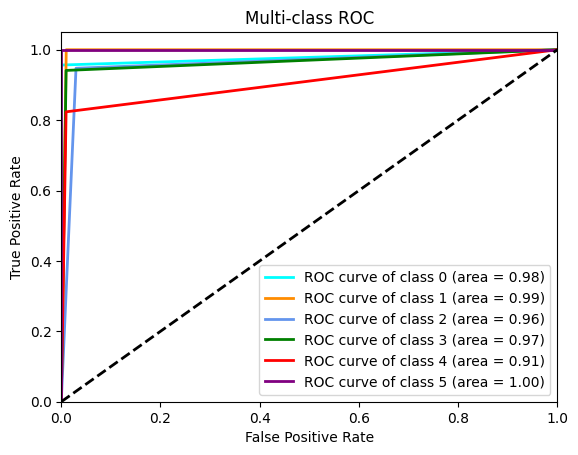

In [6]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights

# Define your dataset directory
dataset_dir = 'D:/CANCER/Prostate Cancer WSI/Prostate_Dataset(short)'

# Initialize empty lists for images and labels
images = []
labels = []

# Define a mapping of class labels to integers
class_to_int = {'GG0': 0, 'GG1': 1, 'GG2': 2, 'GG3': 3, 'GG4': 4, 'GG5': 5}

# Loop through your dataset directory to load images and labels
for category in os.listdir(dataset_dir):
    category_dir = os.path.join(dataset_dir, category)
    for img_filename in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img_filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))  # Resize images to a common size
        images.append(img)  # Keep color images
        labels.append(class_to_int[category])  # Map class labels to integers

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Load a pre-trained ResNet model
resnet = models.resnet50(pretrained=True)
resnet.eval()  # Set the model to evaluation mode

# Modify the ResNet model to remove the final layer
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)

# Define a transform for pre-processing the images for ResNet
transform_resnet = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract features using ResNet
def extract_cnn_features(model, image):
    with torch.no_grad():
        # Apply the transformations and add batch dimension
        image = transform_resnet(image).unsqueeze(0)
        if torch.cuda.is_available():
            image = image.to('cuda')
            model = model.to('cuda')
        features = model(image)
        # Remove the batch dimension and convert to numpy
        features = features.squeeze().cpu().numpy()
    return features

# Extract CNN features for each image
cnn_features_train = np.array([extract_cnn_features(resnet, img) for img in images])

# Check the shape of cnn_features_train
print(cnn_features_train.shape)  # This should give you an idea of the current shape

# Assuming cnn_features_train has shape (num_samples, num_features)
# Reshape it to (num_samples, num_channels, height, width)
# Here, num_channels = 2048 (output channels of ResNet), height = 1, width = 1

X = cnn_features_train.reshape(cnn_features_train.shape[0], 2048, 1, 1)
y = labels

# Split data into training and testing sets before scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the scaled data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create PyTorch datasets and dataloaders with the correctly processed tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(2048, 32, kernel_size=1, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=1, padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=1, stride=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=1, padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=1, stride=1)
        self.fc1 = nn.Linear(128 * 1 * 1, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.dp1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.dp2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 6)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 1 * 1)
        x = self.dp1(torch.relu(self.bn4(self.fc1(x))))
        x = self.dp2(torch.relu(self.bn5(self.fc2(x))))
        x = self.fc3(x)
        return x

# Instantiate the model
model = CNN()

# Example class weights for 6 classes
class_weights = torch.tensor([1.0, 2.0, 0.5, 1.5, 1.2, 0.8])

# Assuming you're using a GPU, you might need to move the weights to the same device as your model and data
if torch.cuda.is_available():
    model = model.to('cuda')
    class_weights = class_weights.to('cuda')

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 50
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    for inputs, labels in train_loader:
        if torch.cuda.is_available():
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    
# Save the model
torch.save(model.state_dict(), 'model.pth')

# Load the model
model = CNN()  # Make sure to initialize the model architecture
model.load_state_dict(torch.load('model.pth'))
model.eval()  # Set the model to evaluation mode

true_labels = []
predictions = []

with torch.no_grad():  # No need to track gradients for validation
    for inputs, labels in test_loader:
        if torch.cuda.is_available():
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Print evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predictions))
print(classification_report(true_labels, predictions))

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Accuracy: {accuracy*100}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

import numpy as np
from itertools import cycle

def plot_roc(true_labels, predictions, n_classes):
    # Convert true_labels and predictions to one-hot encoded format
    true_labels_bin = label_binarize(true_labels, classes=range(n_classes))
    predictions_bin = label_binarize(predictions, classes=range(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.show()

# Call the modified plot_roc function
plot_roc(true_labels, predictions, n_classes=6)

In [31]:
import os
import torch
import torch.nn as nn
import cv2
from torchvision import models, transforms

# Define the CNN architecture (without dropout and batch normalization)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(2048, 32, kernel_size=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=1, stride=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=1, stride=1)
        self.fc1 = nn.Linear(128 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 6)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 1 * 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load the model
model = CNN()
model.load_state_dict(torch.load('D:/CANCER/cnn_model.pth'), strict=False)

# Function to extract features using ResNet
def extract_cnn_features(model, image):
    transform_resnet = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    with torch.no_grad():
        # Apply the transformations and add batch dimension
        image = transform_resnet(image).unsqueeze(0)
        if torch.cuda.is_available():
            image = image.to('cuda')
            model = model.to('cuda')
        features = model(image)
        # Remove the batch dimension and convert to numpy
        features = features.squeeze().cpu().numpy()
    return features

# Function to classify an image
def classify_image(image_path):
    # Check if the file exists
    if not os.path.exists(image_path):
        raise ValueError(f"Image at path {image_path} does not exist.")
    
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    img = cv2.resize(img, (256, 256))  # Resize to match training size

    # Extract features using ResNet
    resnet = models.resnet50(pretrained=True)
    resnet.eval()
    modules = list(resnet.children())[:-1]
    resnet = nn.Sequential(*modules)
    features = extract_cnn_features(resnet, img)

    # Reshape features to match the input shape of the CNN
    features = features.reshape(1, 2048, 1, 1)
    features_tensor = torch.tensor(features, dtype=torch.float32)

    if torch.cuda.is_available():
        features_tensor = features_tensor.to('cuda')
        model.to('cuda')

    # Classify the image using the CNN
    with torch.no_grad():
        output = model(features_tensor)
        _, predicted = torch.max(output, 1)
        class_index = predicted.item()

    # Map the class index to the Gleason score
    int_to_class = {0: 'GG0', 1: 'GG1', 2: 'GG2', 3: 'GG3', 4: 'GG4', 5: 'GG5'}
    gleason_score = int_to_class[class_index]

    return gleason_score

# Load the image
image_path = r'D:\CANCER\18B0006622E_Block_Region_0_1_0_xini_13776_yini_146161.jpg'
gleason_score = classify_image(image_path)
print(f'The Gleason score for the given image is: {gleason_score}')

The Gleason score for the given image is: GG1


In [ ]:
from flask import Flask, request, render_template, redirect, url_for
import os
import torch
import torch.nn as nn
import cv2
from torchvision import models, transforms
from werkzeug.utils import secure_filename

app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = 'uploads'
os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)

# Define the CNN architecture (without dropout and batch normalization)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(2048, 32, kernel_size=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=1, stride=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=1, stride=1)
        self.fc1 = nn.Linear(128 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 6)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 1 * 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load the model
model = CNN()
model.load_state_dict(torch.load('D:/CANCER/cnn_model.pth'), strict=False)

# Function to extract features using ResNet
def extract_cnn_features(model, image):
    transform_resnet = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    with torch.no_grad():
        # Apply the transformations and add batch dimension
        image = transform_resnet(image).unsqueeze(0)
        if torch.cuda.is_available():
            image = image.to('cuda')
            model = model.to('cuda')
        features = model(image)
        # Remove the batch dimension and convert to numpy
        features = features.squeeze().cpu().numpy()
    return features

# Function to classify an image
def classify_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    img = cv2.resize(img, (256, 256))  # Resize to match training size

    # Extract features using ResNet
    resnet = models.resnet50(pretrained=True)
    resnet.eval()
    modules = list(resnet.children())[:-1]
    resnet = nn.Sequential(*modules)
    features = extract_cnn_features(resnet, img)

    # Reshape features to match the input shape of the CNN
    features = features.reshape(1, 2048, 1, 1)
    features_tensor = torch.tensor(features, dtype=torch.float32)

    if torch.cuda.is_available():
        features_tensor = features_tensor.to('cuda')
        model.to('cuda')

    # Classify the image using the CNN
    with torch.no_grad():
        output = model(features_tensor)
        _, predicted = torch.max(output, 1)
        class_index = predicted.item()

    # Map the class index to the Gleason score
    int_to_class = {0: 'GG0', 1: 'GG1', 2: 'GG2', 3: 'GG3', 4: 'GG4', 5: 'GG5'}
    gleason_score = int_to_class[class_index]

    return gleason_score

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        if 'file' not in request.files:
            return redirect(request.url)
        file = request.files['file']
        if file.filename == '':
            return redirect(request.url)
        if file:
            filename = secure_filename(file.filename)
            filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(filepath)
            gleason_score = classify_image(filepath)
            return render_template('result.html', score=gleason_score, image_url=url_for('uploaded_file', filename=filename))
    return render_template('upload.html')

@app.route('/uploads/<filename>')
def uploaded_file(filename):
    return redirect(url_for('static', filename=os.path.join('uploads', filename)))

if __name__ == '__main__':
    app.run(debug=True)